In [1]:
# imports 
from numpy import quantile, random, where
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.datasets import make_blobs
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

In [2]:
new_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
os.chdir(new_dir)

print('In Predictive Model Folder:', os.getcwd())

In Predictive Model Folder: c:\Users\ashly\OneDrive\Documents\Education Material\ResearchProject\MaternalHealthResearch\predictive-model


## Isolation Forest implementation to detect anomalies in heart rate 
# Overview: 
- Group analysis by id's to provide individualistic anomaly tracking
- View resting and activity level anomalies (0,1,2,3) 
- Plot a time series plot for representation of anomalies over time
- Heatmap visualization for correlation in manual input data

Step 1: Build the model to be used on each id

In [63]:
def generateAnomalies(): # moreso analysis and visualizations
    df = pd.read_csv('data_interim/heartrate_mets_intensities_merged_inner.csv')
    analysis_file = open('reports/anomaly_analysis.txt', 'w')
    
    grouped = df.groupby(['id','intensity_level'])
    anomalies = {}
    non_anomalies = {}
    for (id, intensity_level), group in grouped:
        X = group[['bpm','mets']]
        model = IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
        model.fit(X)
        group['anomaly_score'] = model.decision_function(X)
        group['anomaly']=model.predict(X)
        anomalies[(id,intensity_level)] = group[group['anomaly_score'] < 0]
        non_anomalies[(id, intensity_level)] = group[group['anomaly_score'] >= 0]
        # use this anomalies dictionary to analyze further
        text = f'ID: {id}, INTENSITY LEVEL: {intensity_level} = {group.describe()}'
        analysis_file.write(text)
    
    for (id,intensity_level), anomaly_group in anomalies.items():
        anomaly_timestamp = pd.to_datetime(anomaly_group['timestamp'])
        anomaly_timestamp = anomaly_timestamp.dt.day
        plt.figure(figsize=(10, 6))
        plt.plot(anomaly_timestamp, anomaly_group['mets'], label='METs Activity')
        plt.plot(anomaly_timestamp, anomaly_group['bpm'], label='Heart Rate (BPM)')
        plt.scatter(anomaly_timestamp, anomaly_group['mets'], color='red', label='Anomaly (METs Activity)')
        plt.scatter(anomaly_timestamp, anomaly_group['bpm'], color='red', label='Anomaly (Heart Rate)')
        plt.xlabel('Timestamp')
        plt.ylabel('Values')
        plt.title(f'Time Series Plot with Anomalies (ID: {id}) (Intensity Level: {intensity_level})')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    # store the individual anomalies into a dataframe
    dataframes_anomalies = []
    dataframes_non = []
    for key, value in anomalies.items():
        df = pd.DataFrame(value)
        df['id'] = key[0]
        df['intensity_level'] = key[1]
        df['timestamp'] = df['timestamp']
        dataframes_anomalies.append(df)
    
    # anomalies 
    df_merged1 = pd.concat(dataframes_anomalies, ignore_index=True)
    df_merged1.to_csv('data_interim/anomalies_heartrate_intensities.csv', index=False)
    
    for key, value in non_anomalies.items():
        df = pd.DataFrame(value)
        df['id'] = key[0]
        df['intensity_level'] = key[1]
        df['timestamp'] = df['timestamp']
        dataframes_non.append(df)
    
    # non anomalies
    df_merged2 = pd.concat(dataframes_non, ignore_index=True)
    df_merged2.to_csv('data_interim/nonanomalies_heartrate_intensities.csv', index=False)
    
    df_merged = pd.merge(df_merged1, df_merged2, how='outer',on=['id','timestamp','intensity_level','mets','bpm','anomaly_score','anomaly'])
    df_merged['timestamp'] = pd.to_datetime(df_merged['timestamp'], format='%m/%d/%Y %I:%M:%S %p')
    df_merged = df_merged.sort_values(by='timestamp')
    df_merged.to_csv('data_interim/ALL_anomalies_heartrate_intensities.csv', index=False)
    

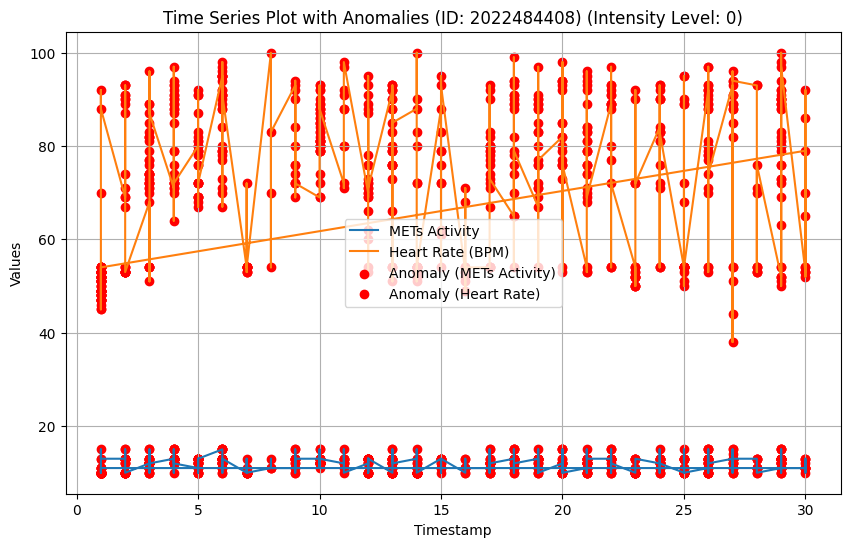

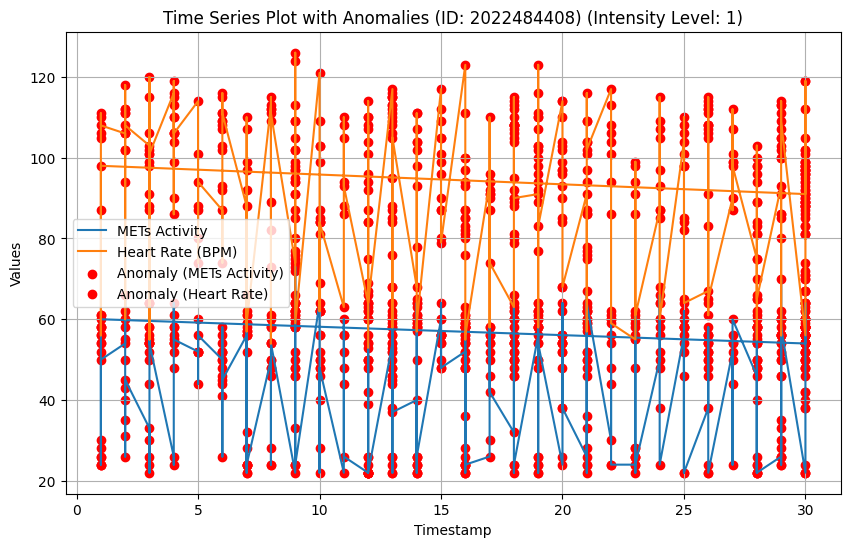

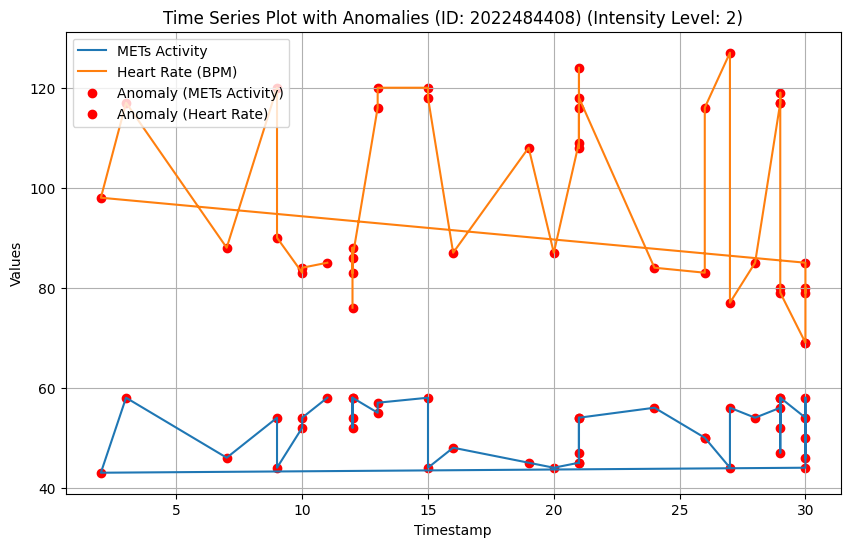

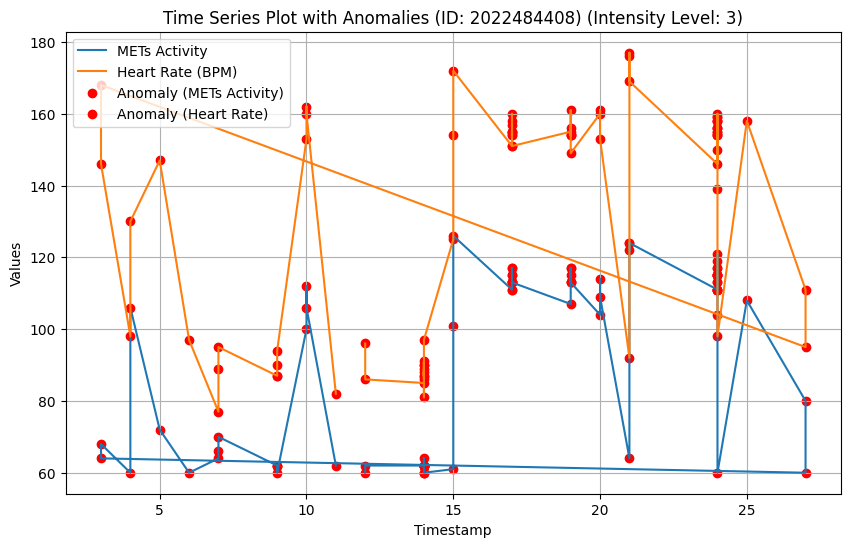

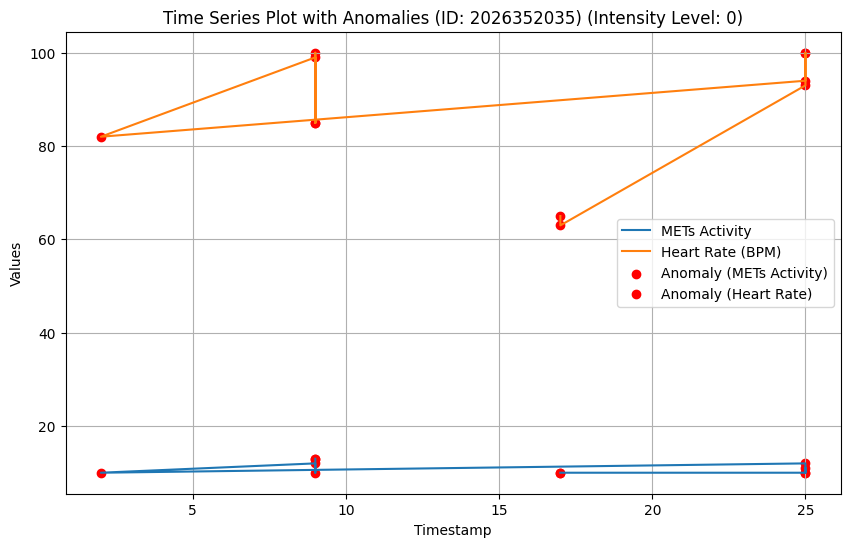

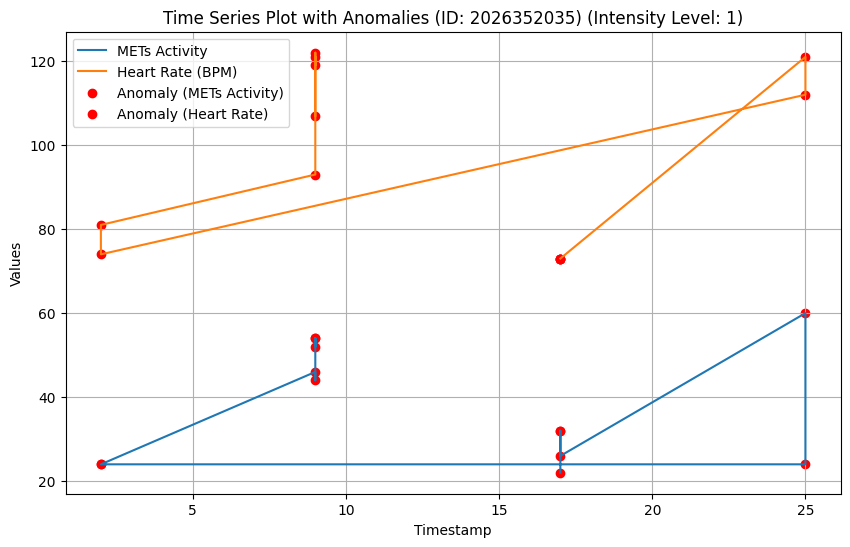

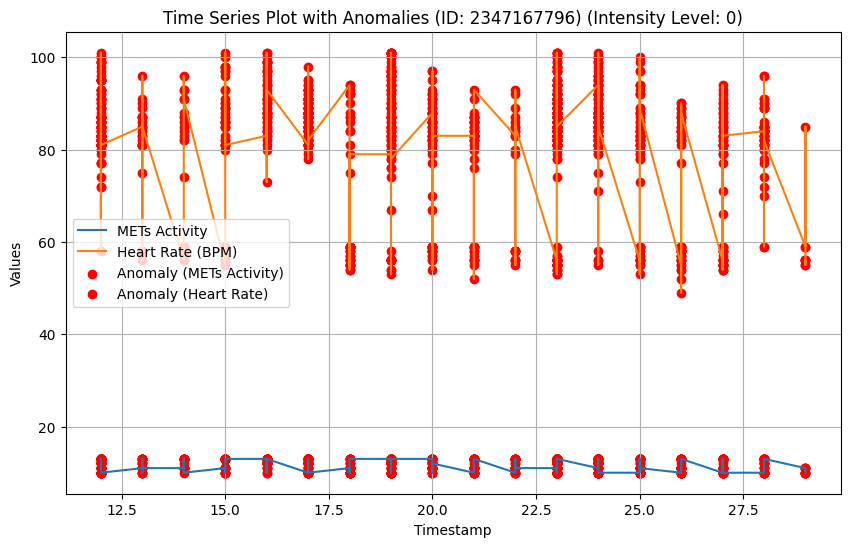

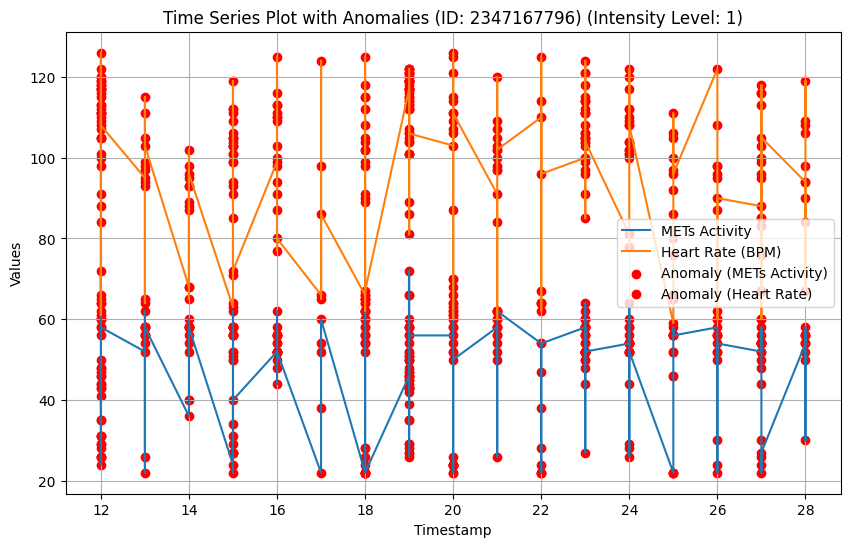

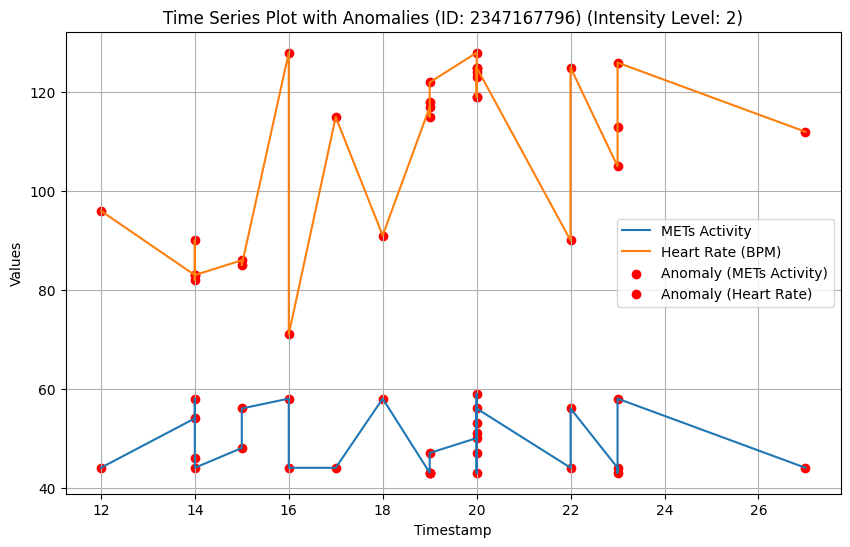

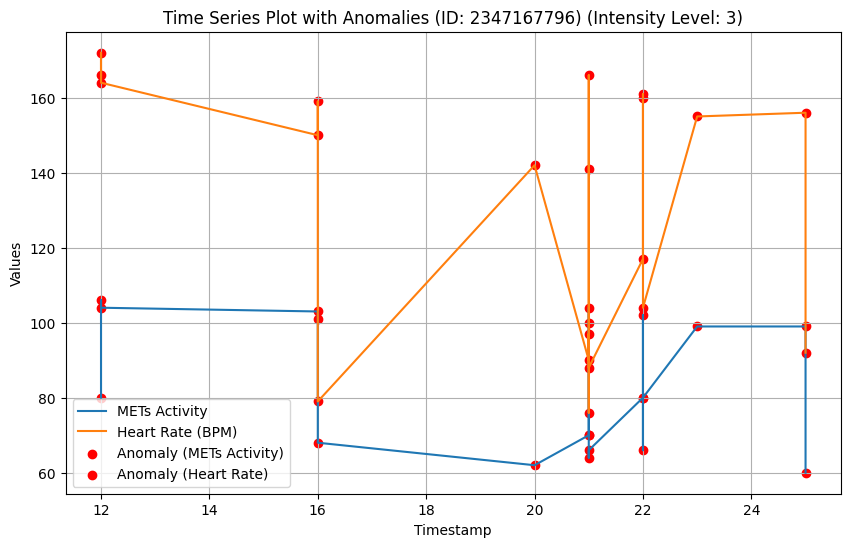

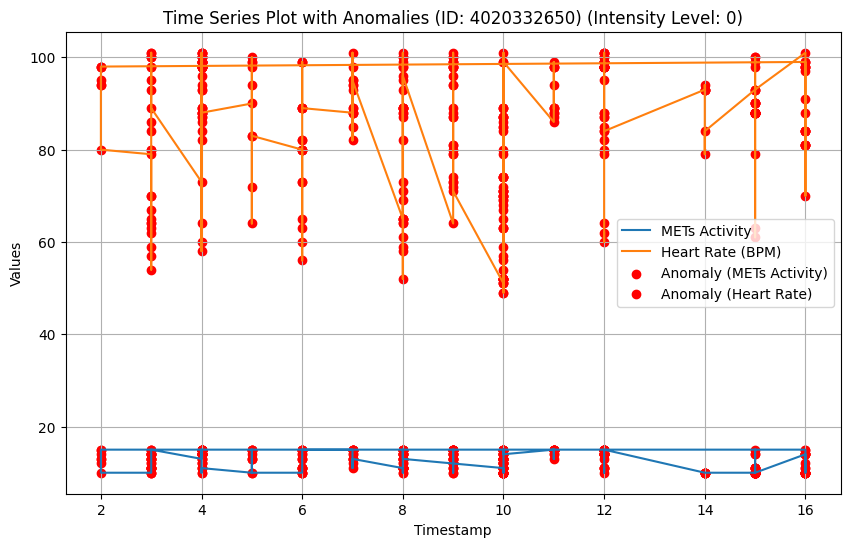

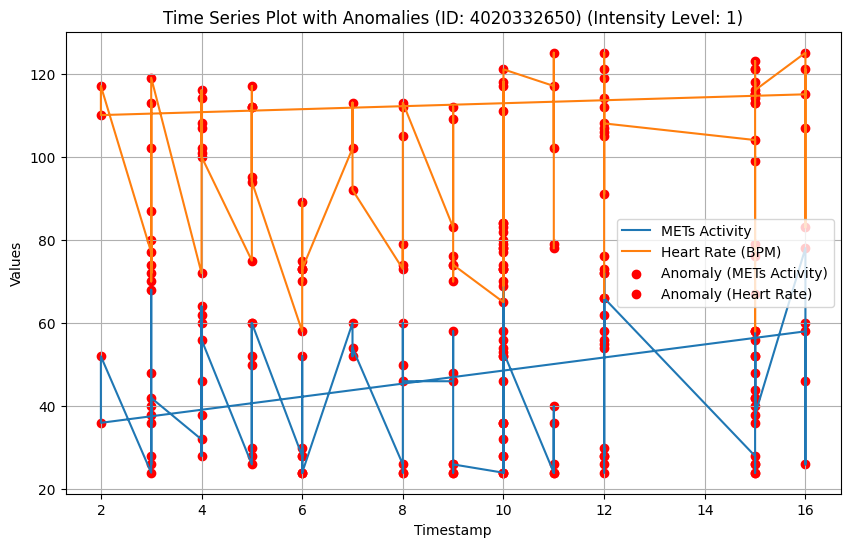

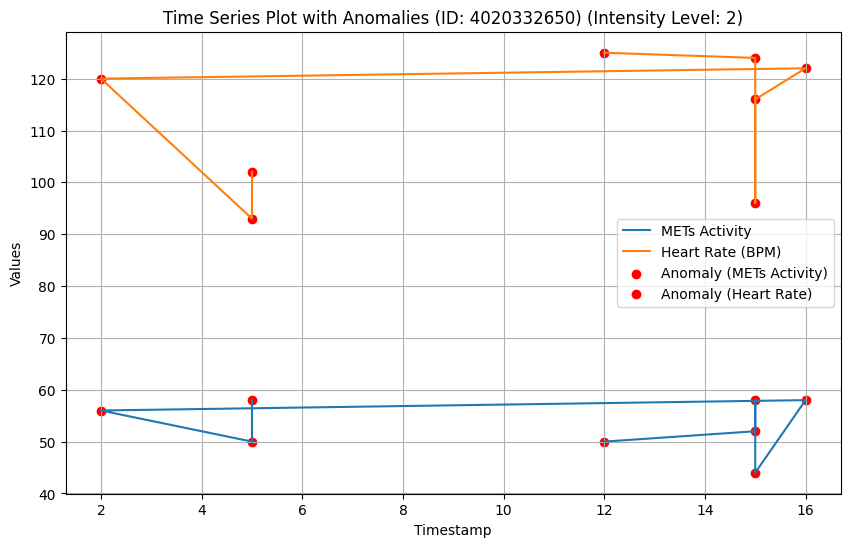

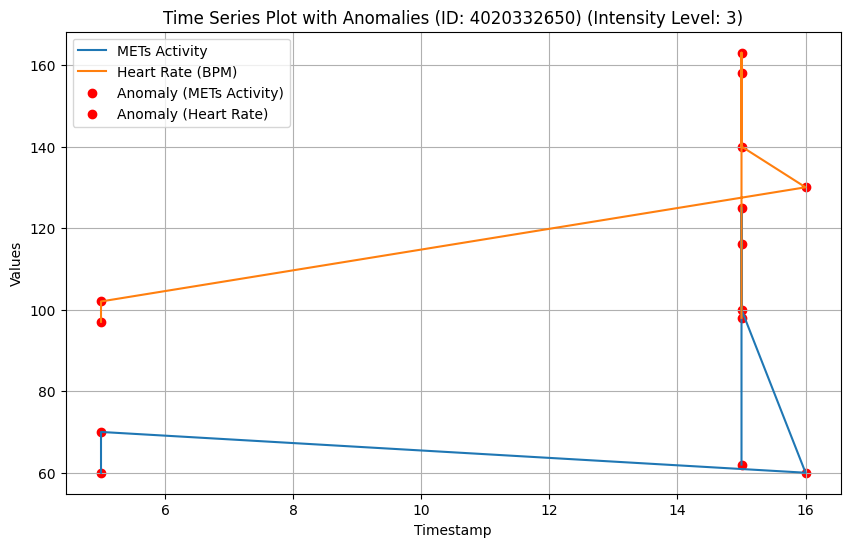

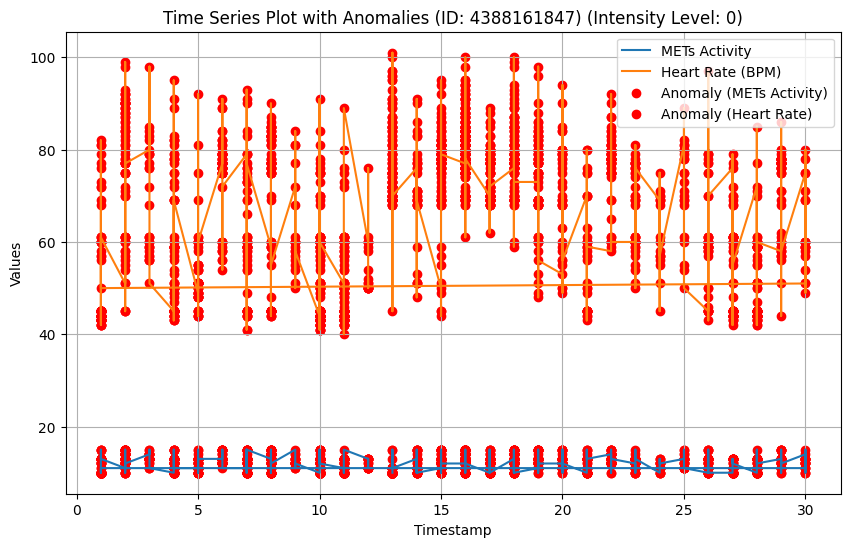

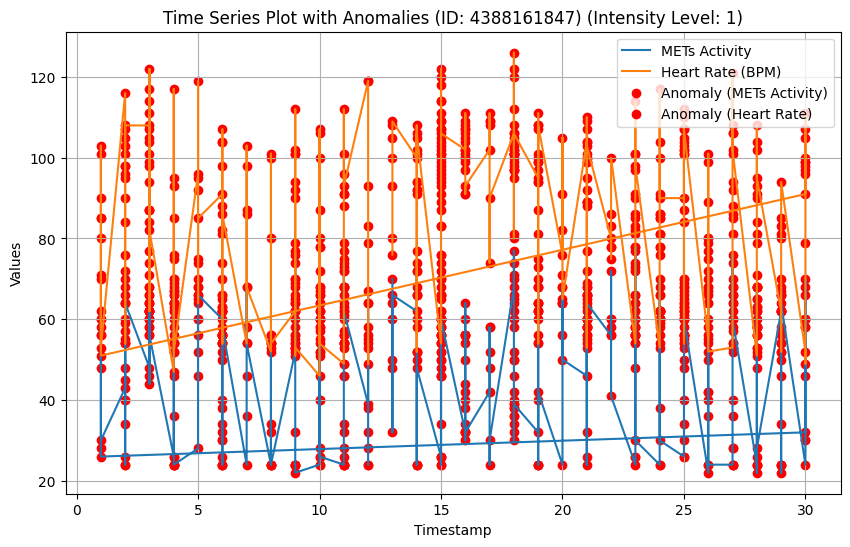

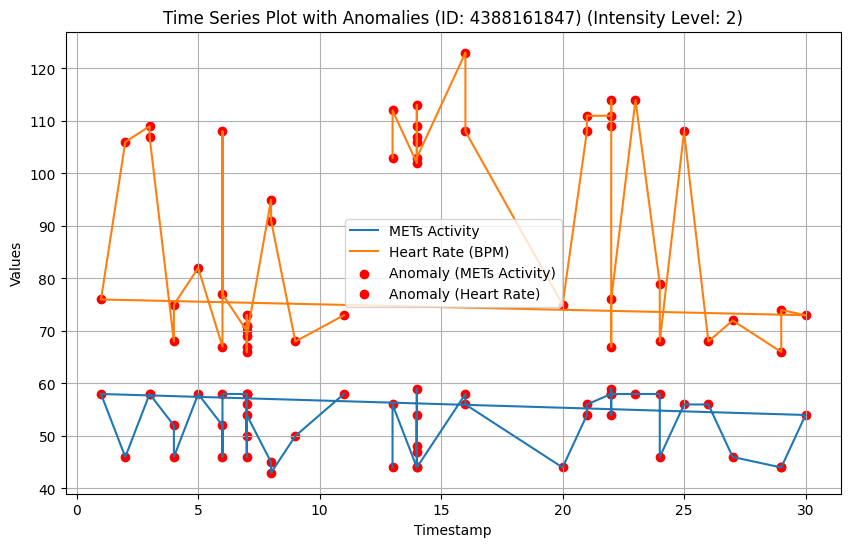

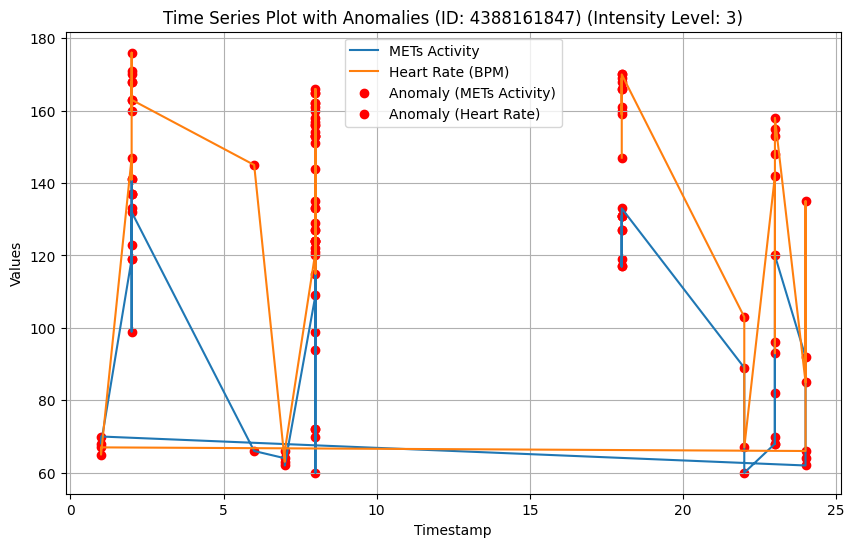

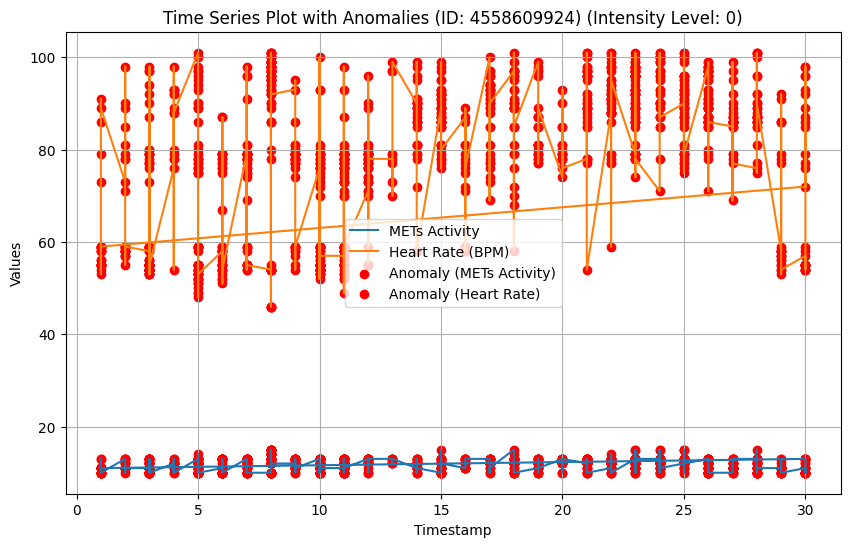

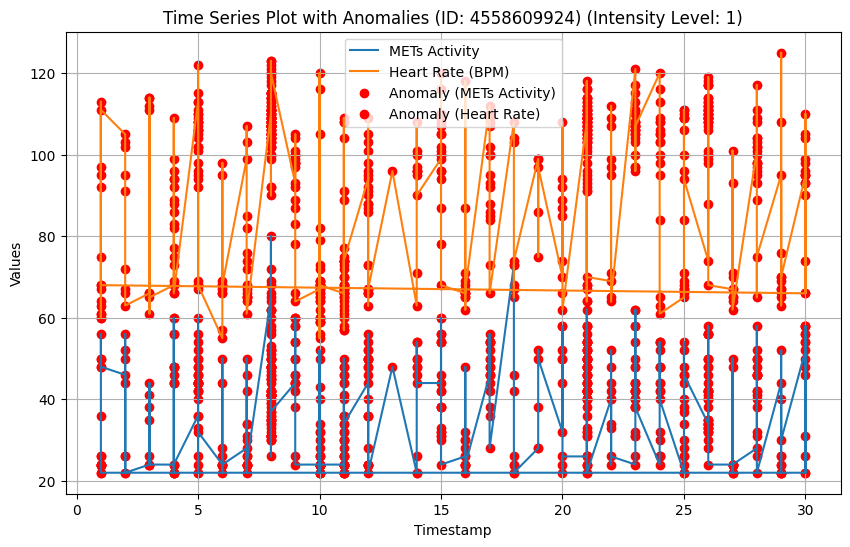

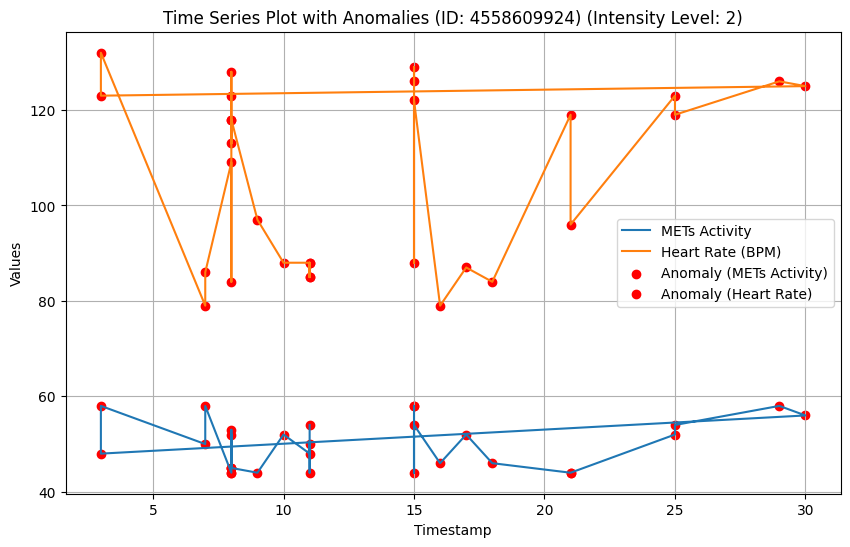

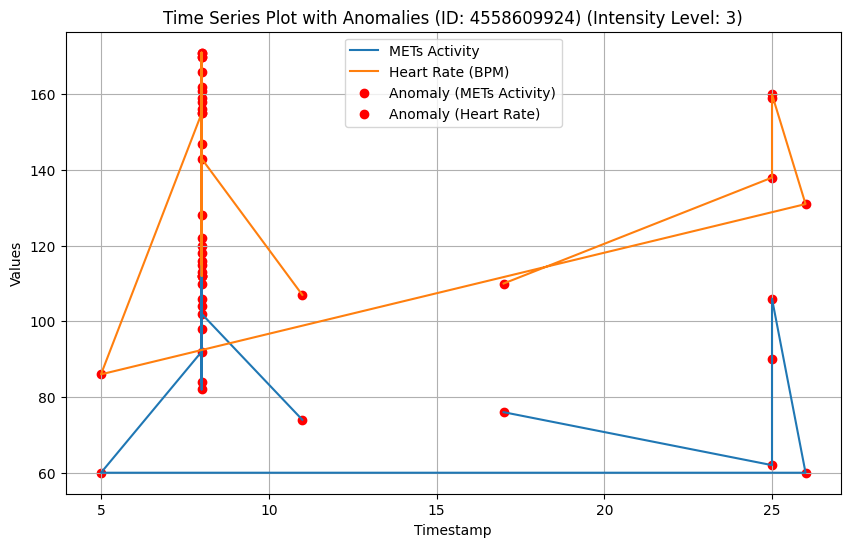

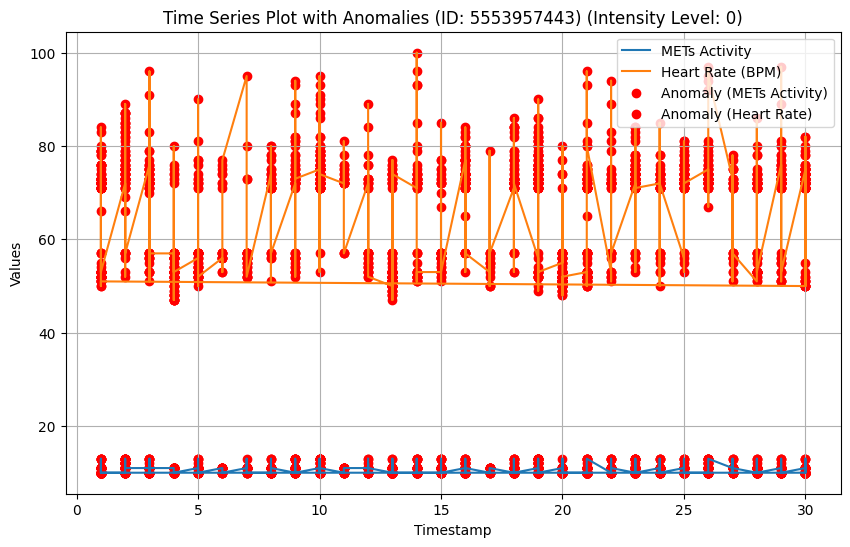

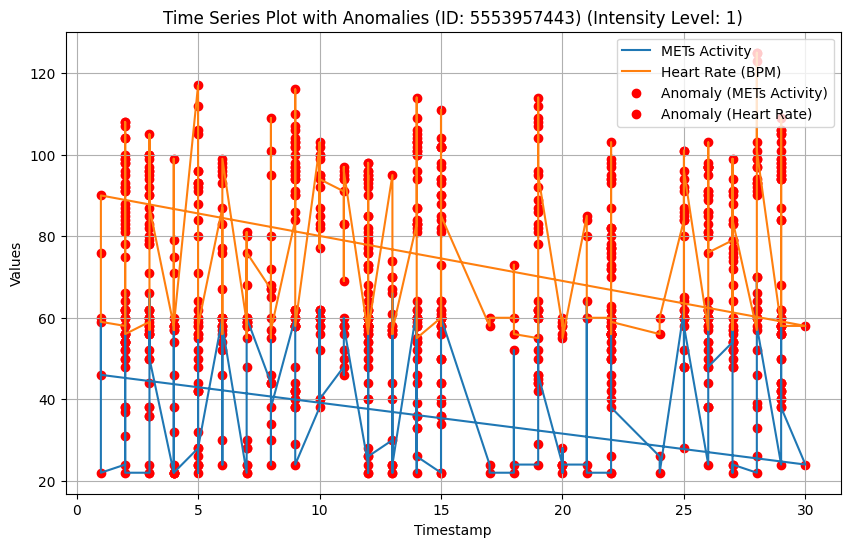

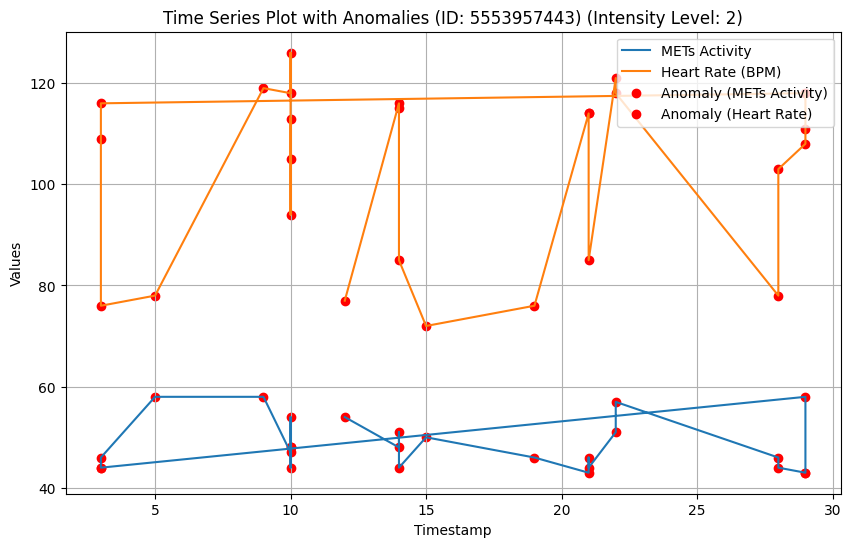

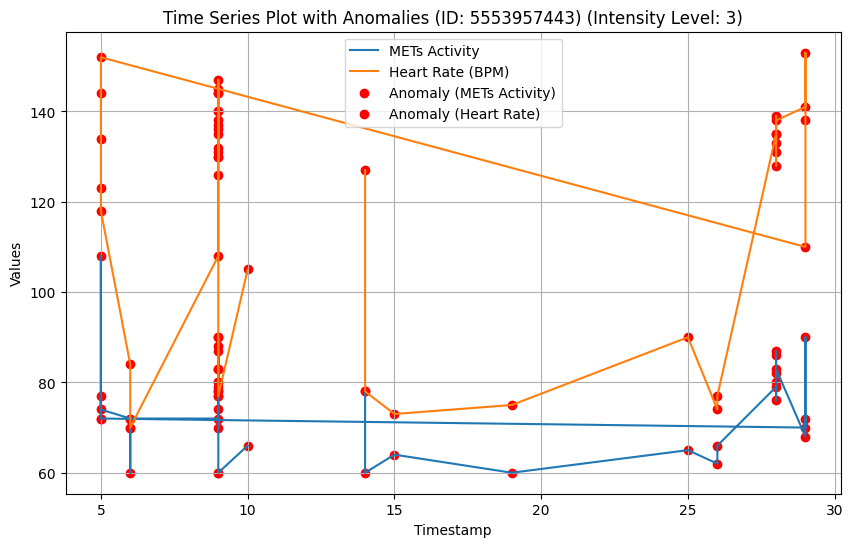

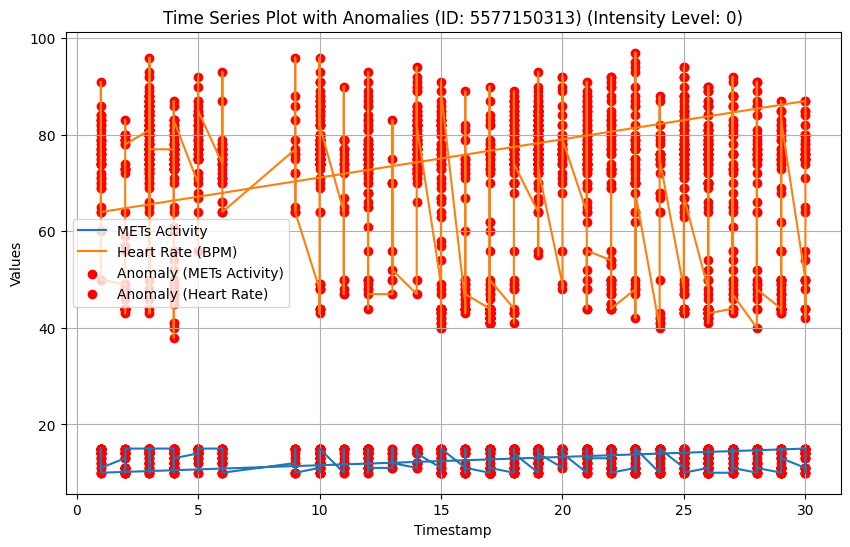

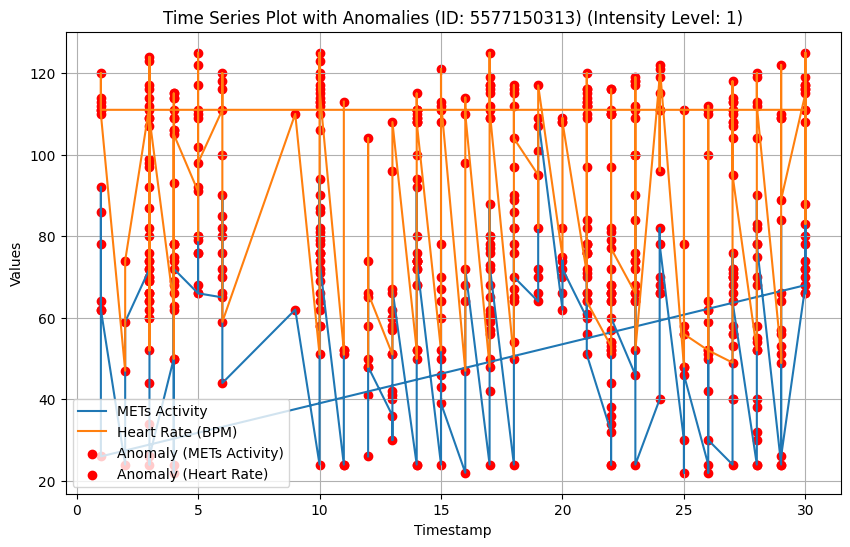

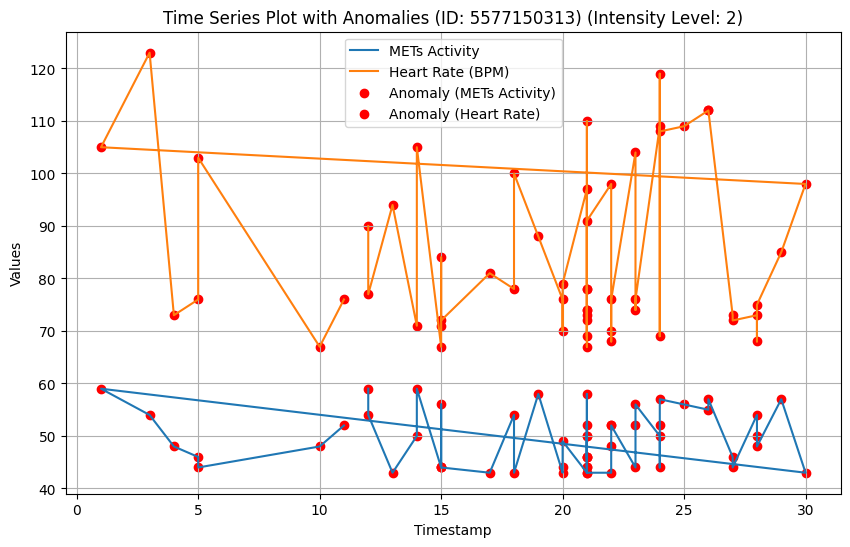

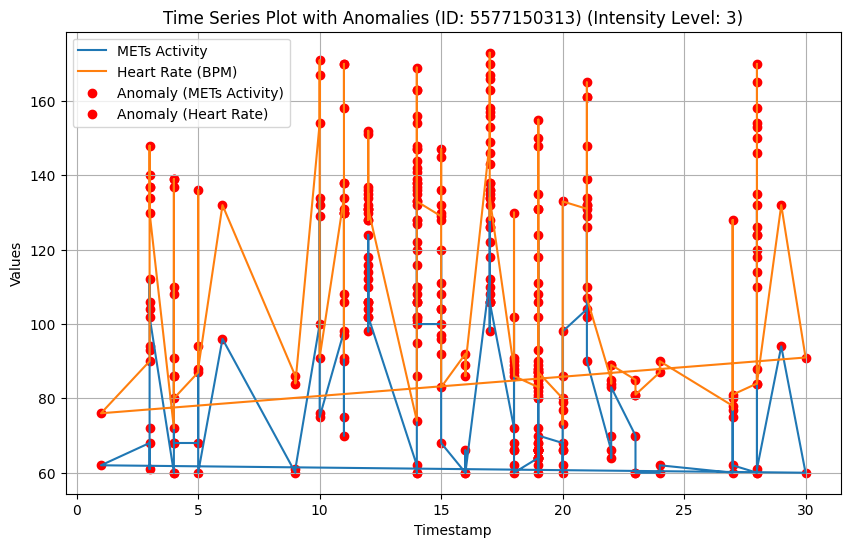

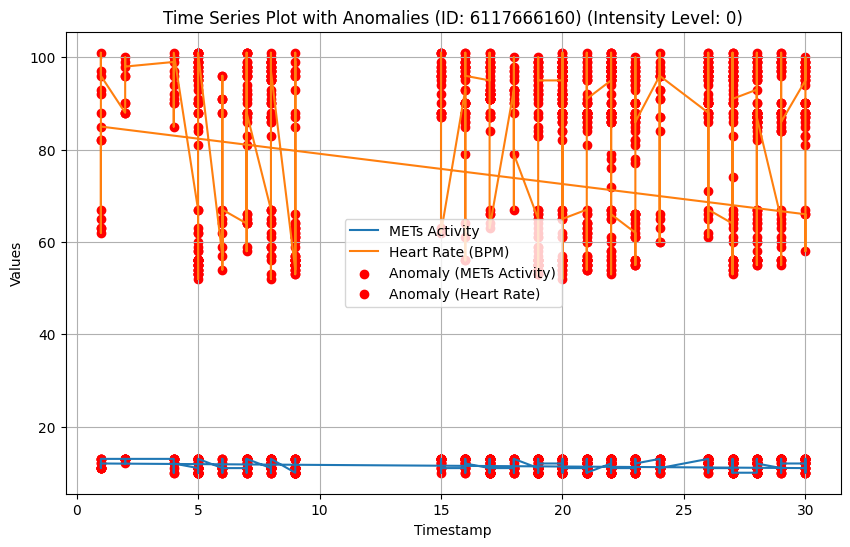

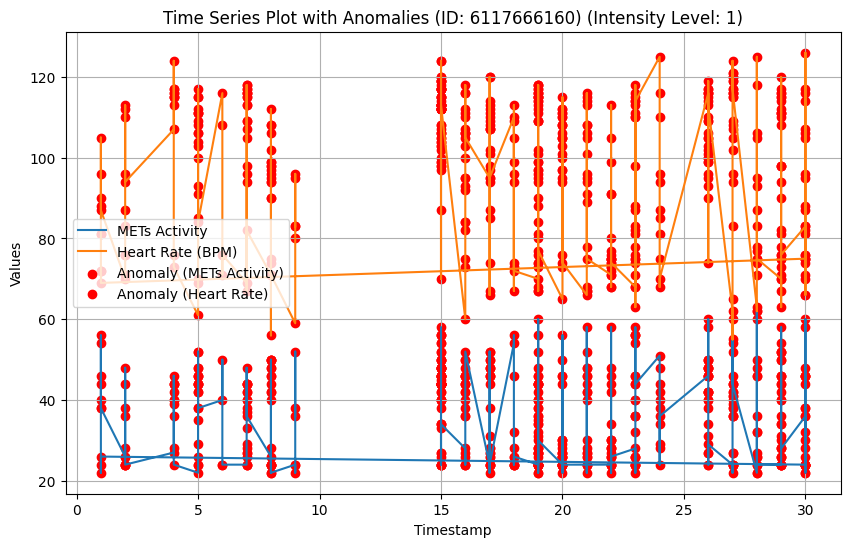

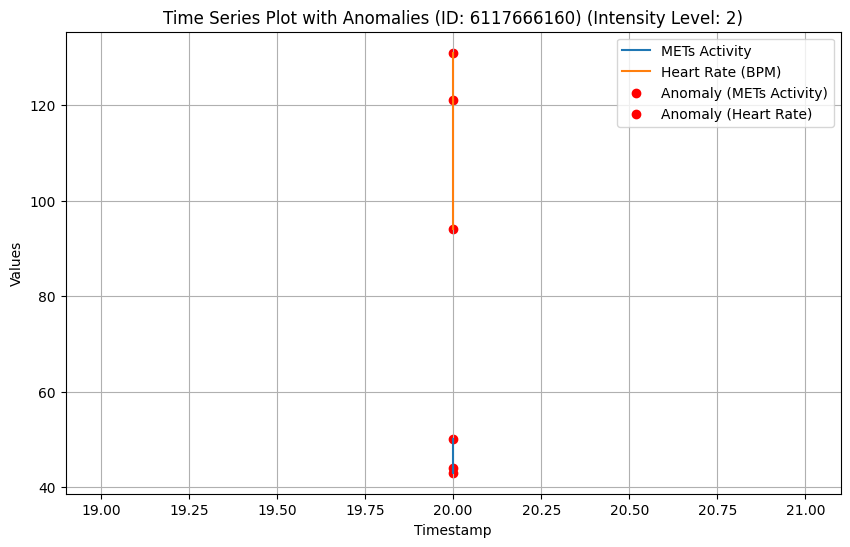

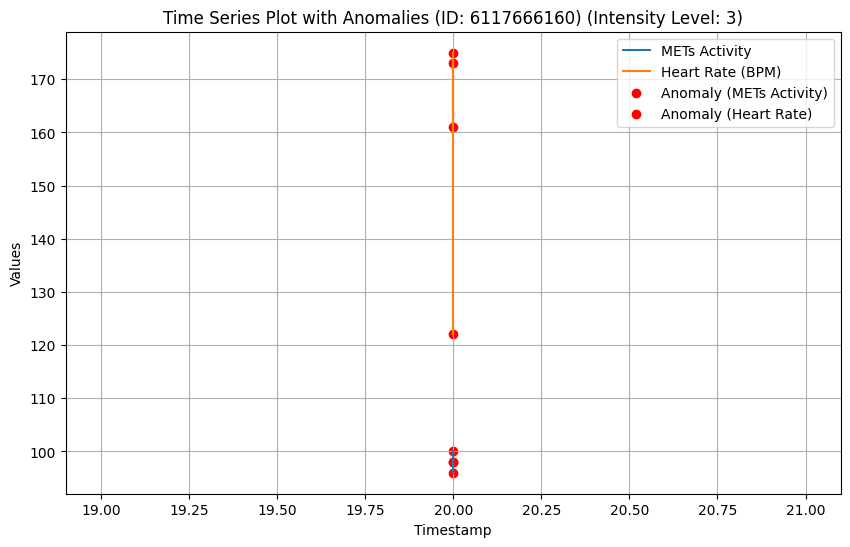

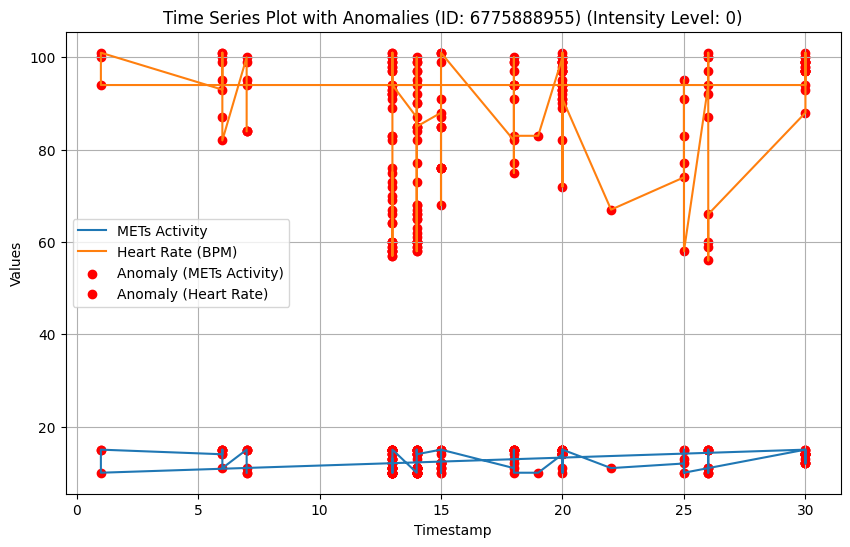

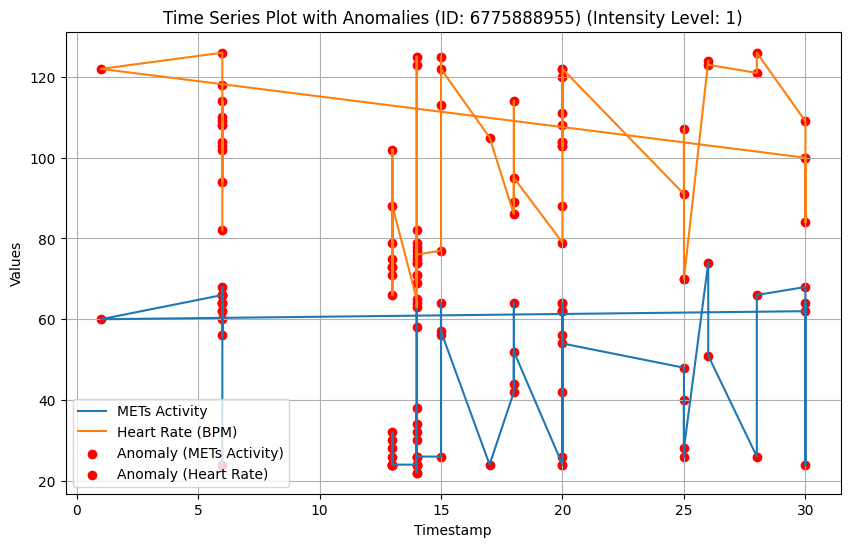

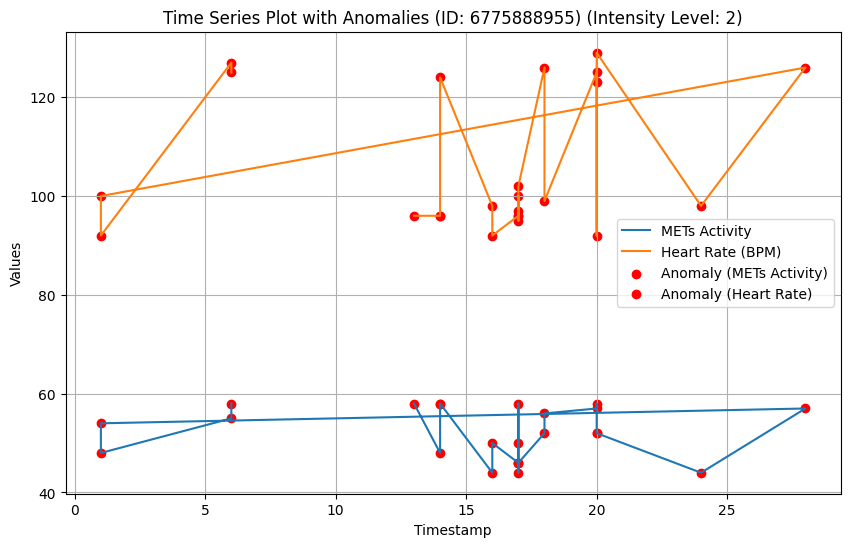

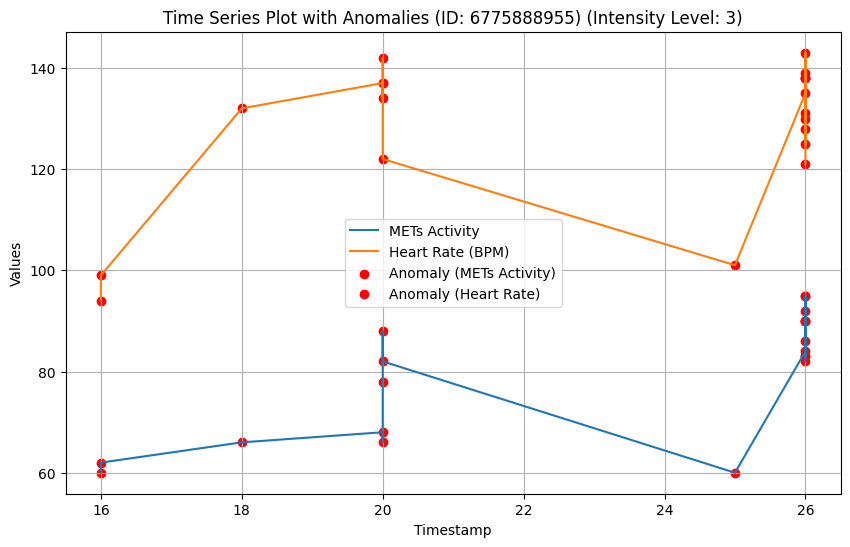

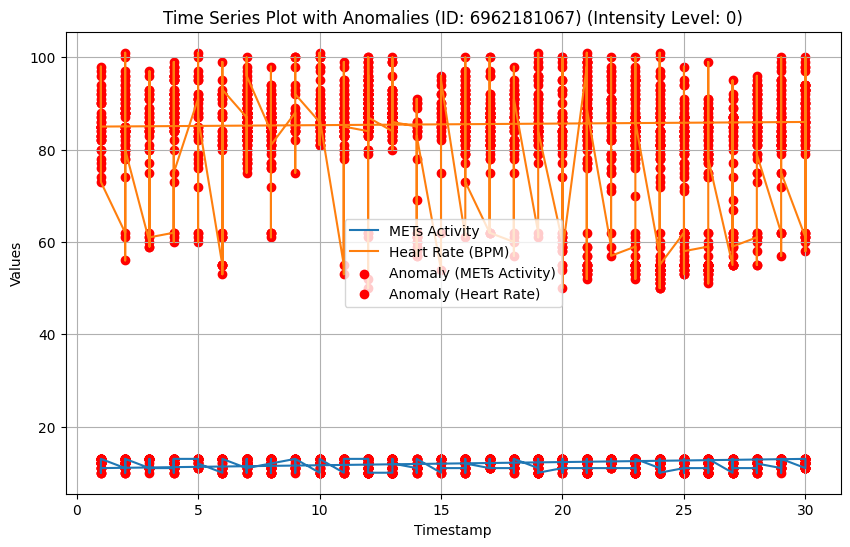

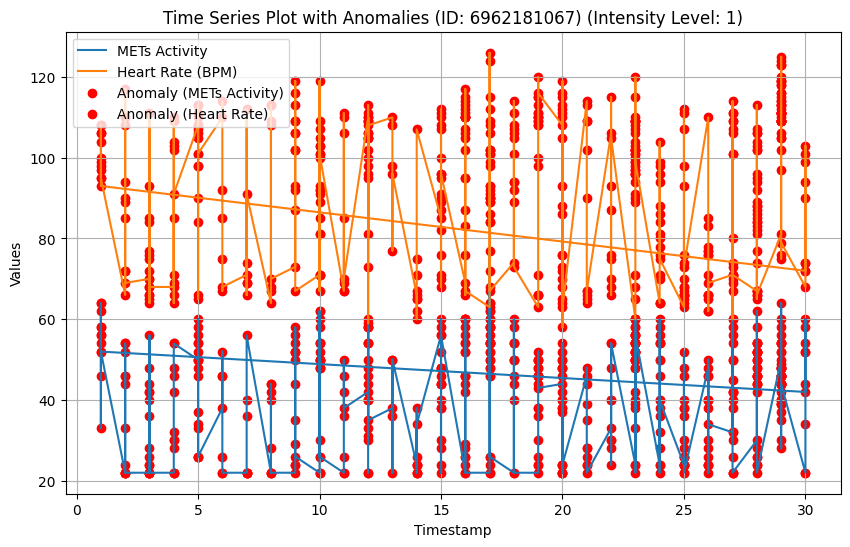

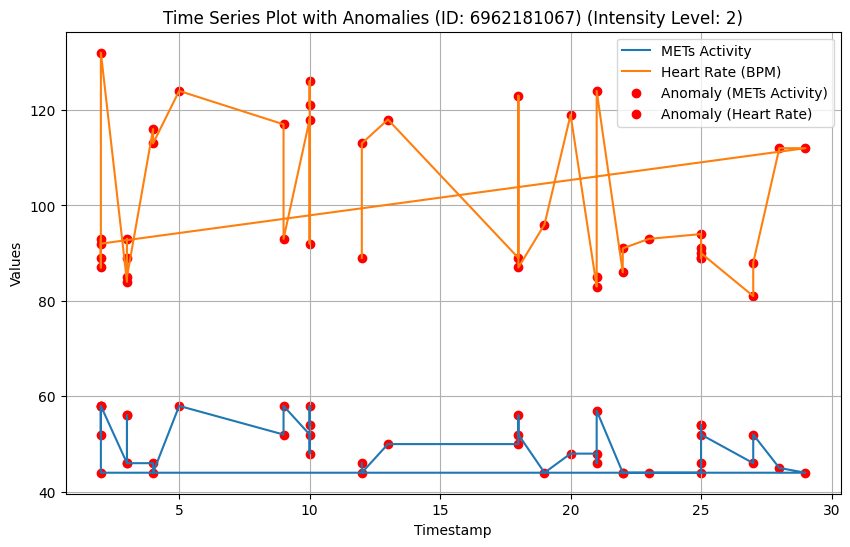

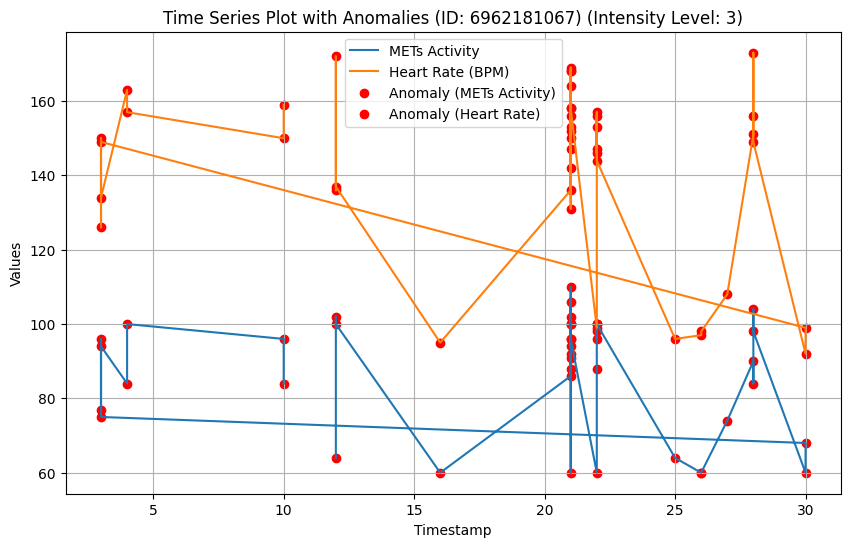

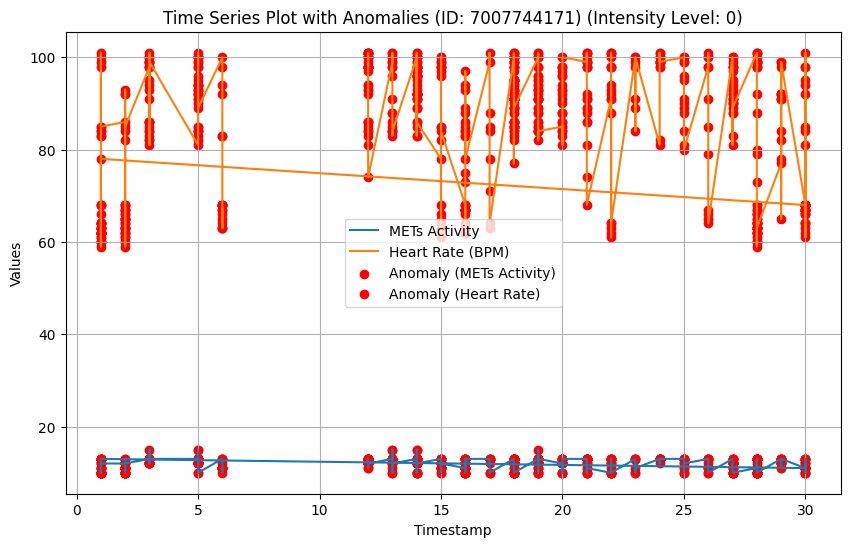

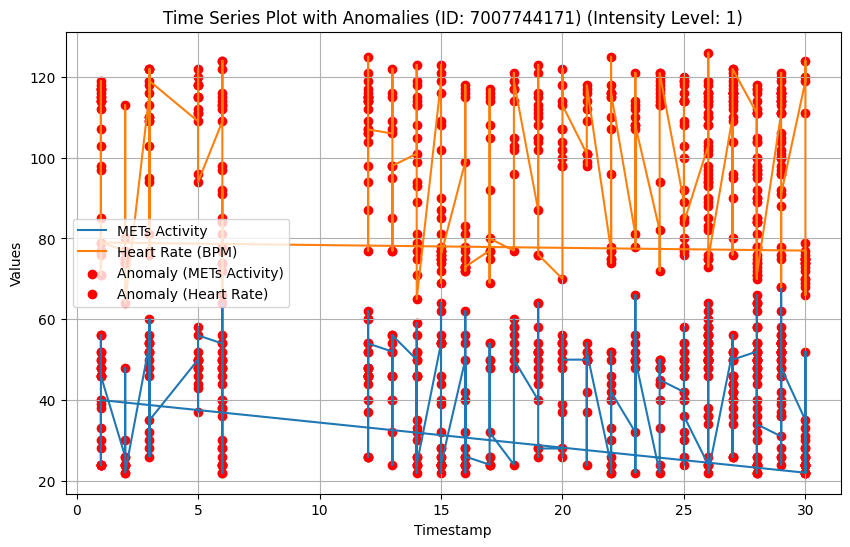

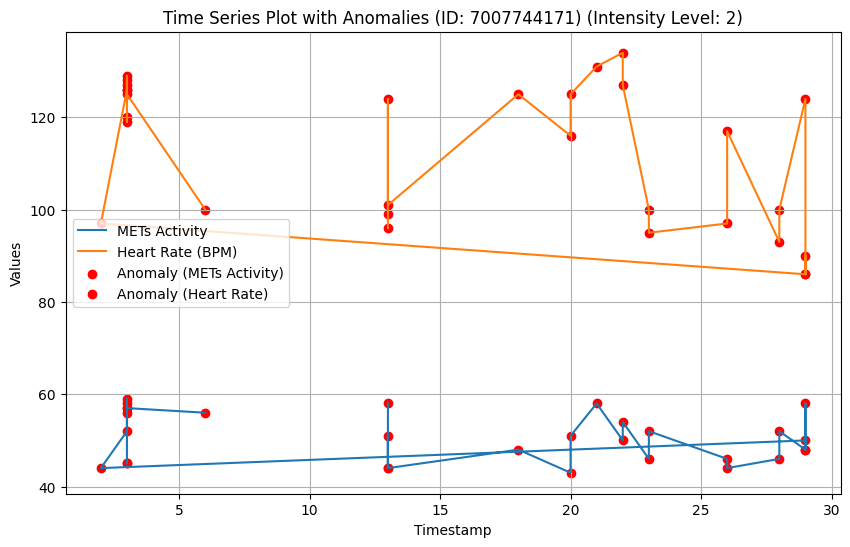

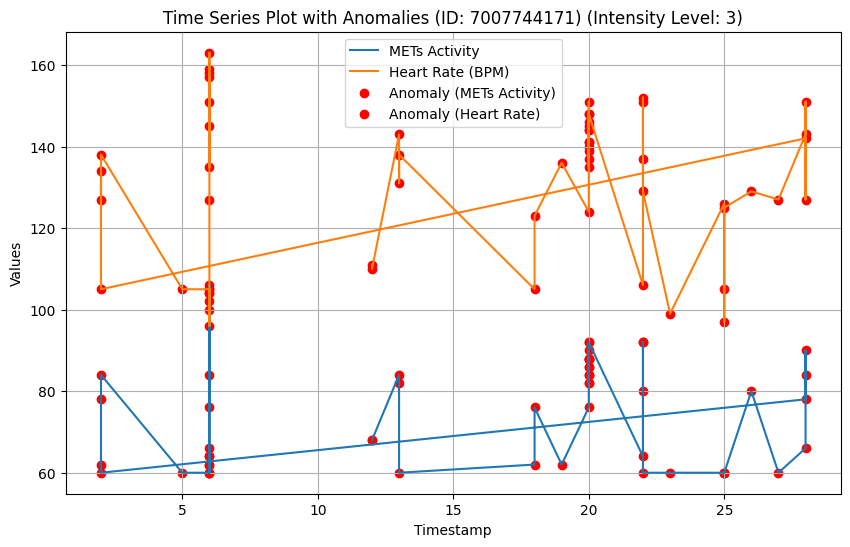

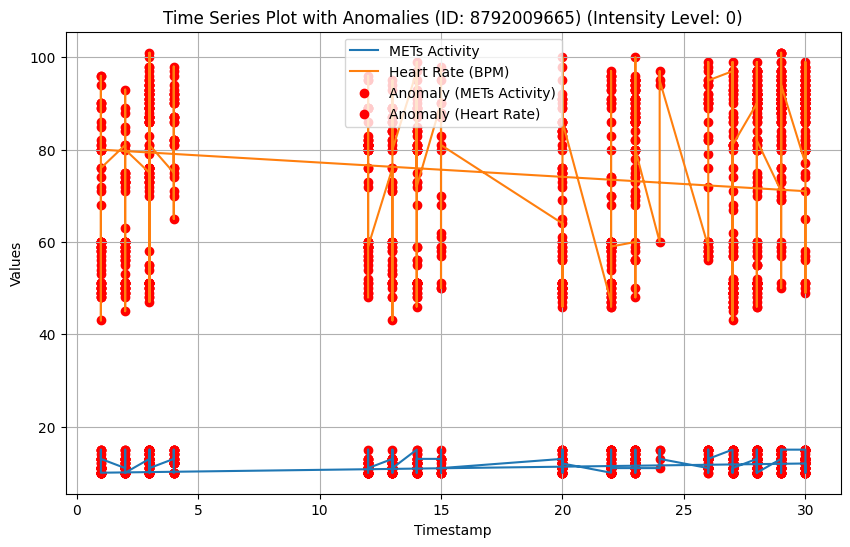

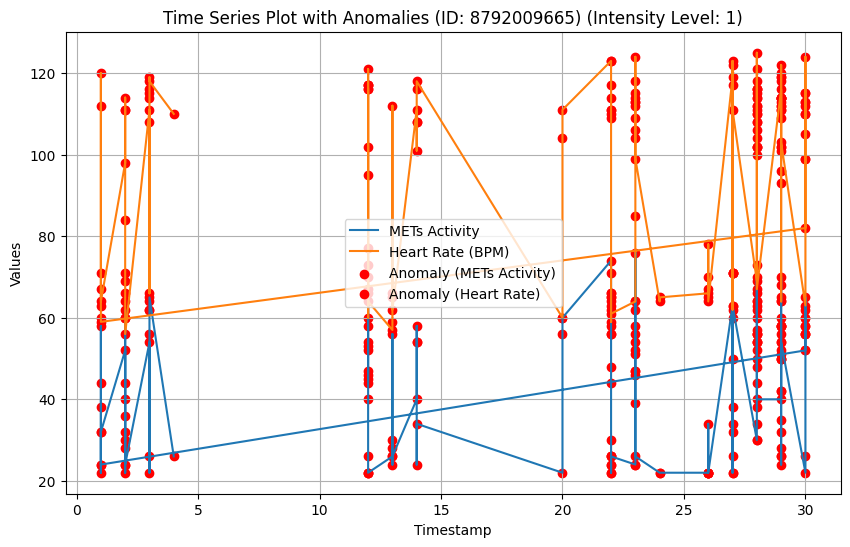

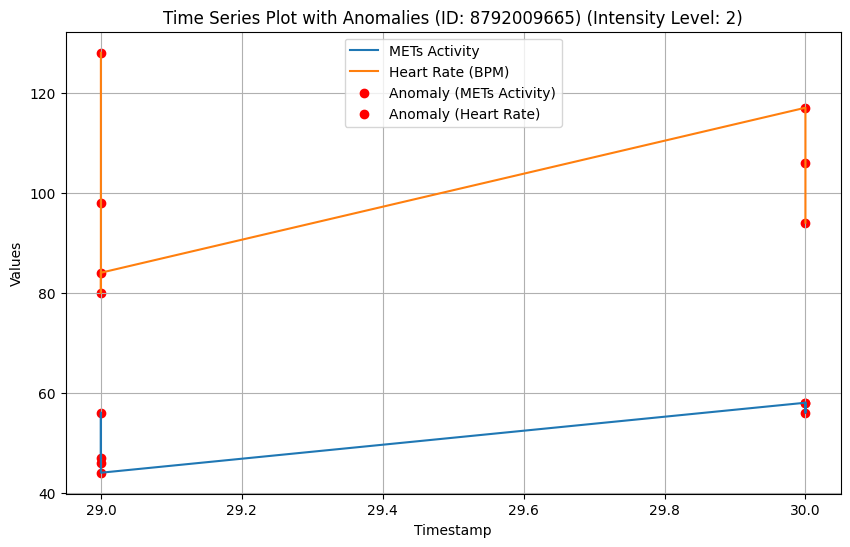

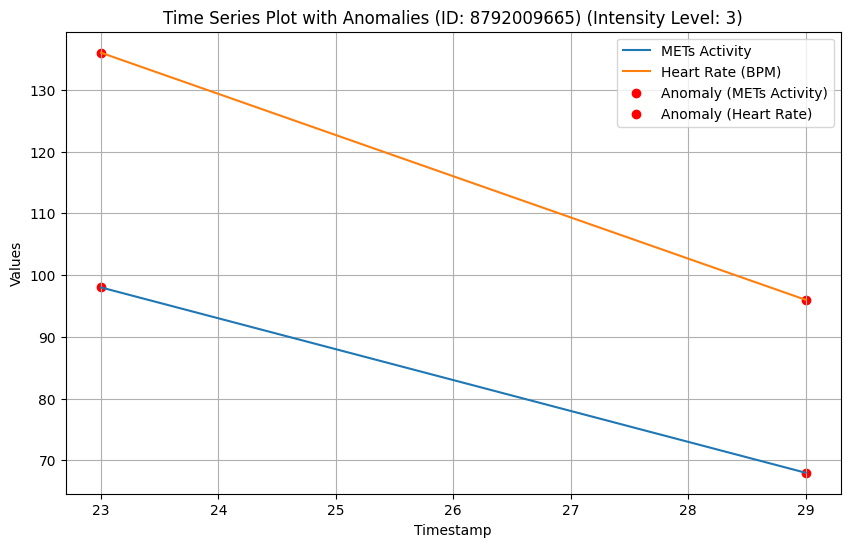

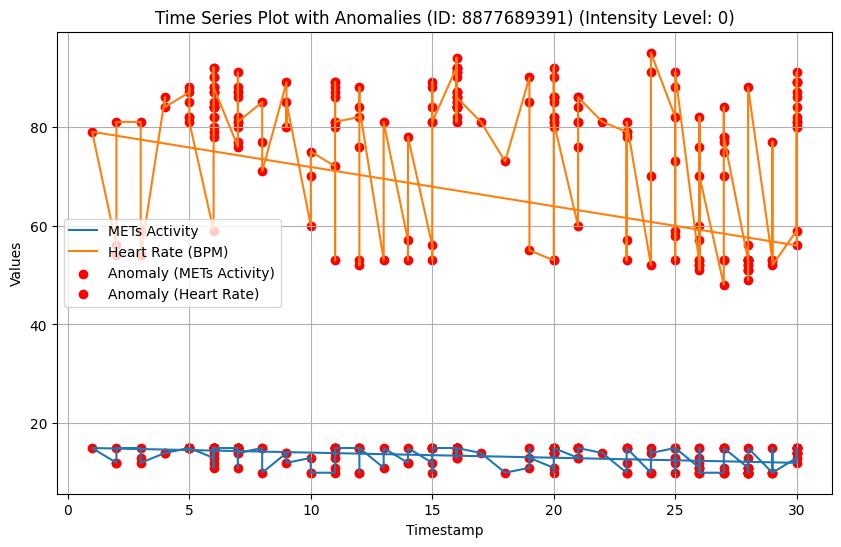

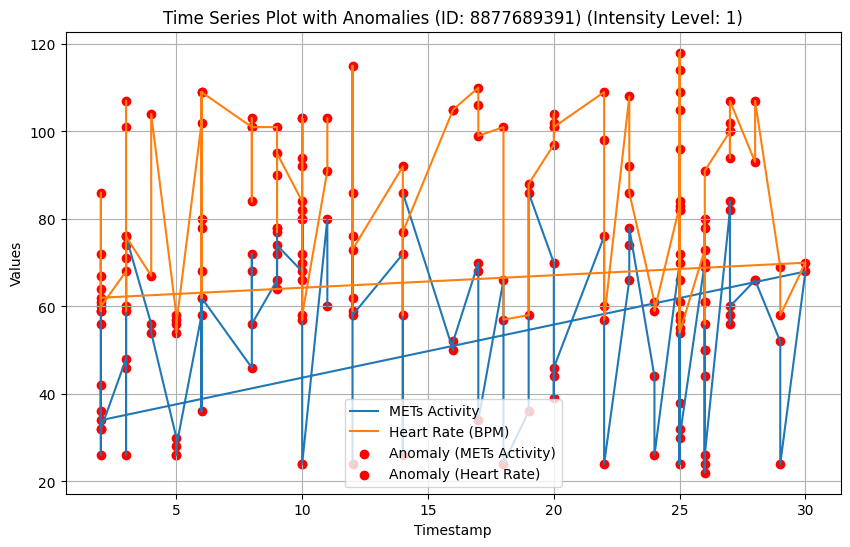

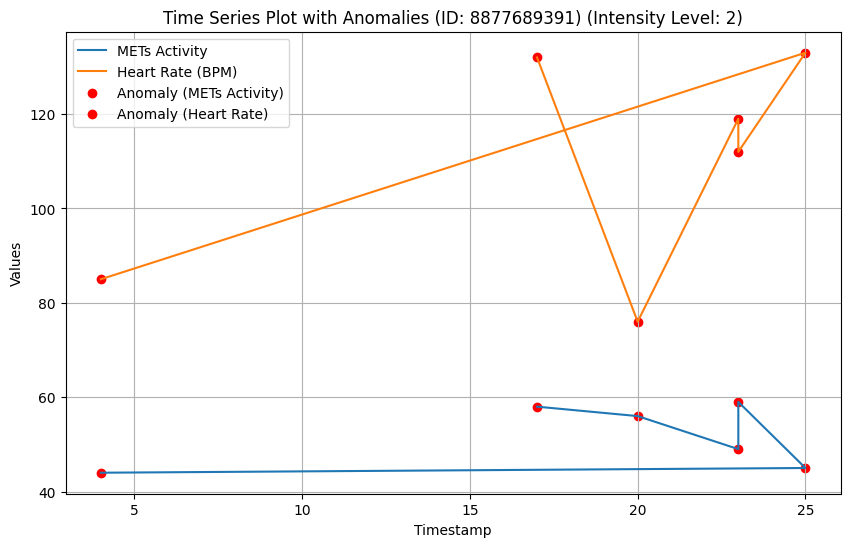

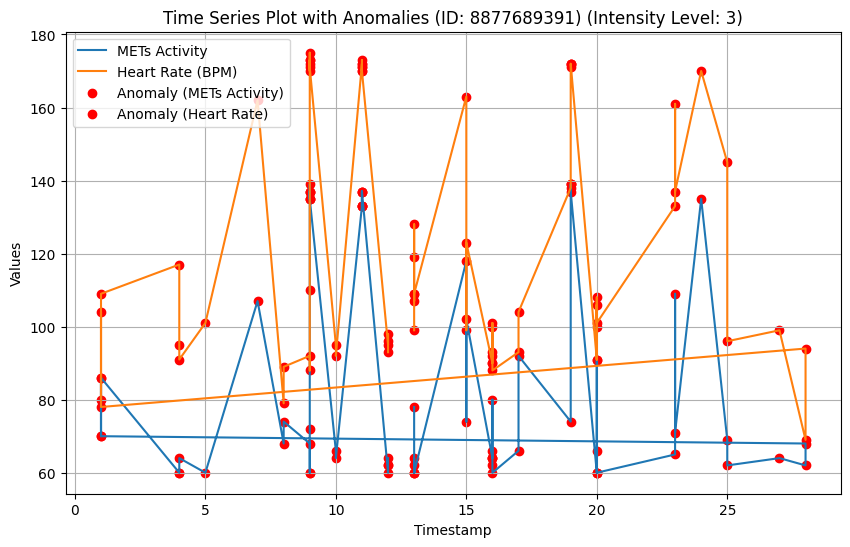

In [64]:
generateAnomalies()

           id             timestamp  intensity_level  mets  bpm
0  2022484408  4/12/2016 7:21:00 AM                1    32   97
1  2022484408  4/12/2016 7:23:00 AM                0    13   60
2  2022484408  4/12/2016 7:24:00 AM                0    10   58
3  2022484408  4/12/2016 7:26:00 AM                1    24   53
4  2022484408  4/12/2016 7:27:00 AM                0    10   53


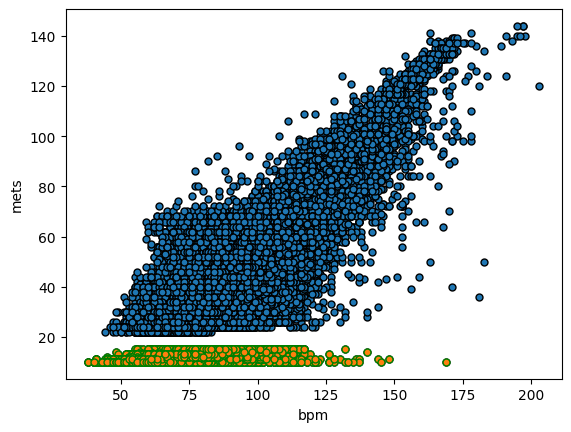

In [3]:
df = pd.read_csv('data_interim/heartrate_mets_intensities_merged_inner.csv')
df_resting = df[df['intensity_level'] < 1] # visual representation of resting heartrates of participants
print(df.head())
plt.xlabel('bpm')
plt.ylabel('mets')
plt.scatter(df['bpm'], df['mets'], marker="o", s=25, edgecolor="k")
plt.scatter(df_resting['bpm'], df_resting['mets'], marker="o", s=25, edgecolor="g")

In [4]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(df[['bpm']])
model_resting=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model_resting.fit(df_resting[['bpm']])

IsolationForest(contamination=0.1, n_estimators=50)

In [5]:
df['scores']=model.decision_function(df[['bpm']])
df['anomaly']=model.predict(df[['bpm']])
df.head(20)

df_resting['scores']=model_resting.decision_function(df_resting[['bpm']])
df_resting['anomaly']=model_resting.predict(df_resting[['bpm']])
df_resting.head(20)

C:\Users\ashly\AppData\Local\Temp\ipykernel_31868\1591406302.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resting['scores']=model_resting.decision_function(df_resting[['bpm']])
C:\Users\ashly\AppData\Local\Temp\ipykernel_31868\1591406302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_resting['anomaly']=model_resting.predict(df_resting[['bpm']])


id             timestamp  intensity_level  mets  bpm    scores  \
1   2022484408  4/12/2016 7:23:00 AM                0    13   60  0.110709   
2   2022484408  4/12/2016 7:24:00 AM                0    10   58  0.108444   
4   2022484408  4/12/2016 7:27:00 AM                0    10   53  0.041748   
7   2022484408  4/12/2016 7:35:00 AM                0    11   67  0.121795   
9   2022484408  4/12/2016 7:45:00 AM                0    13   83  0.050943   
10  2022484408  4/12/2016 7:48:00 AM                0    13   78  0.078270   
21  2022484408  4/12/2016 8:03:00 AM                0    12   73  0.111188   
23  2022484408  4/12/2016 8:06:00 AM                0    13   80  0.073477   
24  2022484408  4/12/2016 8:07:00 AM                0    13   79  0.077779   
28  2022484408  4/12/2016 8:17:00 AM                0    13   81  0.049179   
29  2022484408  4/12/2016 8:18:00 AM                0    10   59  0.103750   
30  2022484408  4/12/2016 8:19:00 AM                0    10   62  0.120875   
31  2022484408  4/12/2016 8:21:00 AM                0    10   59  0.103750   
32  2022484408  4/12/2016 8:22:00 AM                0    11   62  0.120875   
33  2022484408  4/12/2016 8:24:00 AM                0    10   58  0.108444   
34  2022484408  4/12/2016 8:25:00 AM                0    10   58  0.108444   
35  2022484408  4/12/2016 8:26:00 AM                0    11   64  0.115970   
36  2022484408  4/12/2016 8:27:00 AM                0    10   60  0.110709   
37  2022484408  4/12/2016 8:28:00 AM                0    11   59  0.103750   
38  2022484408  4/12/2016 8:29:00 AM                0    11   61  0.113313   

    anomaly  
1         1  
2         1  
4         1  
7         1  
9         1  
10        1  
21        1  
23        1  
24        1  
28        1  
29        1  
30        1  
31        1  
32        1  
33        1  
34        1  
35        1  
36        1  
37        1  
38        1

In [7]:
anomaly=df.loc[df['anomaly']==-1]
anomaly_index=list(anomaly.index)
print('Anomaly:',anomaly)

anomaly_resting=df_resting.loc[df_resting['anomaly']==-1]
anomaly_index_resting=list(anomaly.index)
print('Anomaly Resting:',anomaly)

Anomaly:                 id              timestamp  intensity_level  mets  bpm  \
18      2022484408   4/12/2016 8:00:00 AM                1    42  106   
19      2022484408   4/12/2016 8:01:00 AM                1    46  105   
98      2022484408  4/12/2016 10:05:00 AM                3    66  114   
99      2022484408  4/12/2016 10:06:00 AM                3    70  111   
100     2022484408  4/12/2016 10:07:00 AM                3    68  114   
...            ...                    ...              ...   ...  ...   
200008  8877689391   5/11/2016 5:42:00 PM                3   123  159   
200009  8877689391   5/11/2016 5:47:00 PM                3   108  132   
200010  8877689391   5/11/2016 5:49:00 PM                3    71  114   
200011  8877689391   5/11/2016 5:50:00 PM                2    57  111   
200012  8877689391   5/11/2016 5:52:00 PM                2    53  108   

          scores  anomaly  
18     -0.012949       -1  
19     -0.004670       -1  
98     -0.070759       -1  
99

In [ ]:
outliers_counter = len(df[df['bpm'] > 170])
outliers_counter

57

In [ ]:
print("Accuracy percentage:", 100*list(df['anomaly']).count(-1)/(outliers_counter))

Accuracy percentage: 33868.42105263158
